In [1]:
from openmm import *
import numpy as np
from openmm.app import *
import openmm.unit as unit
from FultonMarket import FultonMarket
from FultonMarketUtils import *
from datetime import datetime

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
save_dir = 'test_US/test_trailblazing'
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

In [3]:
centroid_8_files = 'test_US/centroid_8.pdb', 'test_US/centroid_8_sys.xml'
centroid_1_files = 'test_US/centroid_1.pdb', 'test_US/centroid_1_sys.xml'

pdb = PDBFile(centroid_8_files[0])
with open(centroid_8_files[-1], 'r') as f:
    system_8_init = XmlSerializer.deserialize(f.read())
openmm_topology = pdb.topology
mdtraj_topology = md.Topology.from_openmm(openmm_topology)

stdout_fn = os.path.join(save_dir, 'trailblazing.stdout')
dcd_fn = os.path.join(save_dir, 'trailblazing.dcd')

#### Simulate for 1 nanosecond and then shift the spring centers

In [4]:
num_replicates = 25
temp_min, temp_max = 300*unit.kelvin, 367.447*unit.kelvin
pressure = 1*unit.bar
spring_constant = 83.68*spring_constant_unit #20 cal/(mol * ang^2)
spring_centers = make_interpolated_positions_array(centroid_8_files[0], centroid_1_files[0], num_replicates)

/tmp/ipykernel_26437/1960276747.py:5: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  spring_centers = make_interpolated_positions_array(centroid_8_files[0], centroid_1_files[0], num_replicates)


In [5]:
#Assign the restraints to the thermodynamic states
restraint_selection_string = 'protein and ('
intracellular_inds = [84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349]
intracellular_inds = [ind - 67 for ind in intracellular_inds]
for ind in intracellular_inds:
    restraint_selection_string += f'(resid {ind}) or '
restraint_selection_string = restraint_selection_string[:-4] + ')'

In [6]:
ts = 2*unit.femtosecond
n_frames_per_replicate = 2500
time_btw_frames = 1*unit.picosecond

n_steps_per_frame = round(time_btw_frames / ts)
nstdout = n_steps_per_frame // 5
n_frames_total = n_frames_per_replicate * num_replicates

In [40]:
nstdout * ts, n_frames_total * time_btw_frames

(Quantity(value=200, unit=femtosecond), Quantity(value=62500, unit=picosecond))

In [7]:
init_positions = pdb.getPositions(asNumpy=True)
init_box_vectors = system_8_init.getDefaultPeriodicBoxVectors()

In [8]:
#Ensure that these files don't exist yet
for fname in [dcd_fn, stdout_fn]: 
    if os.path.isfile(fname): 
        os.remove(fname)

#Reporter Parameters
SDR_params = dict(file=stdout_fn, reportInterval=nstdout, step=True, time=True,
                  potentialEnergy=True, temperature=True, progress=False,
                  remainingTime=False, speed=True, volume=True,
                  totalSteps=n_frames_total, separator=' : ')
DCDR_params = dict(file=dcd_fn, reportInterval=n_steps_per_frame)

for i, spring_center in enumerate(spring_centers):
    #Deep copy the init system, without the restraints or barostat, then add them
    system = copy.deepcopy(system_8_init)
    restrain_openmm_system_by_dsl(system, mdtraj_topology, restraint_selection_string, spring_constant, spring_center)
    system.addForce(MonteCarloBarostat(pressure, temp_max, 100))
    
    #Define the integrator and simulation etc.
    integrator = LangevinIntegrator(temp_max, 1/unit.picosecond, ts)
    platform = Platform.getPlatformByName('OpenCL')
    properties = {'OpenCLPrecision': 'mixed'}
    simulation = Simulation(openmm_topology, system, integrator, platform, properties)
    
    #First simulation checks, set positions and start reporters differently
    if i == 0:
        simulation.context.setPositions(init_positions)
        simulation.context.setVelocitiesToTemperature(temp_max)
        for param_set in [SDR_params, DCDR_params]:
            param_set['append'] = False
    else:
        simulation.context.setPositions(last_state.getPositions())
        simulation.context.setVelocities(last_state.getVelocities())
        for param_set in [SDR_params, DCDR_params]:
            param_set['append'] = True
    
    #Init and append reporters
    SDR = StateDataReporter(**SDR_params)
    DCDR = DCDReporter(**DCDR_params)
    simulation.reporters.append(SDR)
    simulation.reporters.append(DCDR)

    #Run that bish
    simulation.minimizeEnergy()
    start = datetime.now()
    simulation.step(n_steps_per_frame * n_frames_per_replicate)
    print(f"Time to simulate replicate {i} for {n_frames_per_replicate * time_btw_frames} was {datetime.now() - start}")

    #After the run, we need the state to set the next positions
    last_state = simulation.context.getState(getPositions=True, getVelocities=True)

Time to simulate replicate 0 for 2500 ps was 0:21:38.842245
Time to simulate replicate 1 for 2500 ps was 0:21:40.533112
Time to simulate replicate 2 for 2500 ps was 0:21:40.148570
Time to simulate replicate 3 for 2500 ps was 0:21:38.275428
Time to simulate replicate 4 for 2500 ps was 0:21:43.160243
Time to simulate replicate 5 for 2500 ps was 0:21:43.453740
Time to simulate replicate 6 for 2500 ps was 0:21:40.823296
Time to simulate replicate 7 for 2500 ps was 0:21:43.704554
Time to simulate replicate 8 for 2500 ps was 0:21:48.451793
Time to simulate replicate 9 for 2500 ps was 0:21:46.708478
Time to simulate replicate 10 for 2500 ps was 0:21:43.192901
Time to simulate replicate 11 for 2500 ps was 0:21:50.918465
Time to simulate replicate 12 for 2500 ps was 0:21:49.818206
Time to simulate replicate 13 for 2500 ps was 0:21:53.706248
Time to simulate replicate 14 for 2500 ps was 0:21:45.625882
Time to simulate replicate 15 for 2500 ps was 0:21:49.826998
Time to simulate replicate 16 for 

In [9]:
raise Exception("You merely adopted the darkness. \n I was born in it, molded by it. \n I never saw the light until I was already a man, \n and by then it was nothing but blinding.")

Exception: You merely adopted the darkness. 
 I was born in it, molded by it. 
 I never saw the light until I was already a man, 
 and by then it was nothing but blinding.

In [13]:
def parse_stdout(stdout_fn):
    #Read
    with open(stdout_fn, 'r') as f:
        lines = f.readlines()
    data = [line[:-1].split(' : ') for line in lines]
    #Parse headers
    headers = data[0]
    data = data[1:]
    # Turn everything to floats
    data = np.array([[float(elem) for elem in data[i]] for i in range(len(data))])
    data = {headers[i]: data[:, i] for i in range(len(headers))}
    return data

In [14]:
data = parse_stdout(stdout_fn)

In [33]:
data['#"Step"'].shape[0] / num_replicates

12500.0

In [34]:
import matplotlib.pyplot as plt
slice_indices = np.linspace(0, 5*n_frames_per_replicate*(num_replicates - 1), num_replicates, dtype=int)
print(slice_indices)

[     0  12500  25000  37500  50000  62500  75000  87500 100000 112500
 125000 137500 150000 162500 175000 187500 200000 212500 225000 237500
 250000 262500 275000 287500 300000]


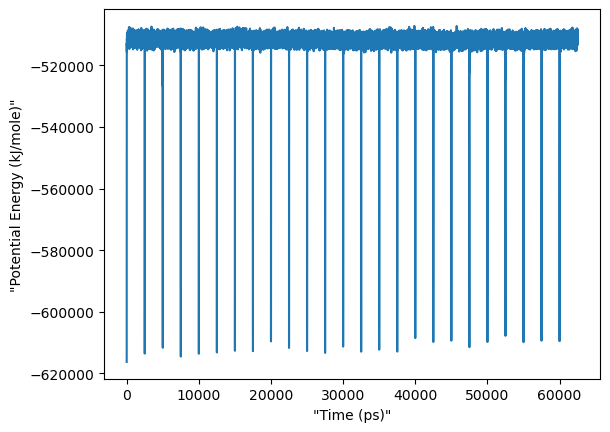

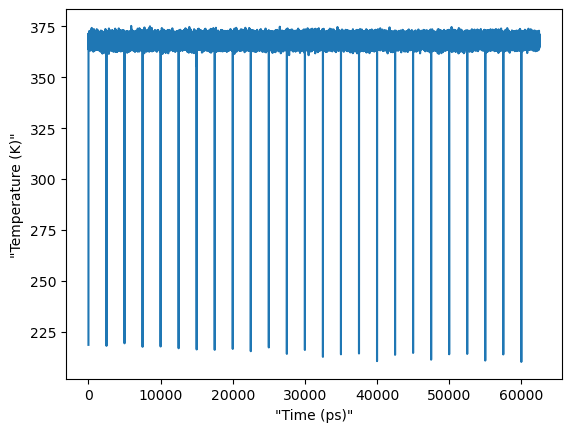

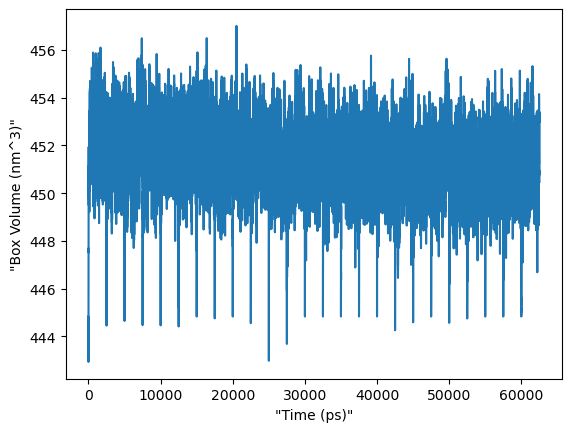

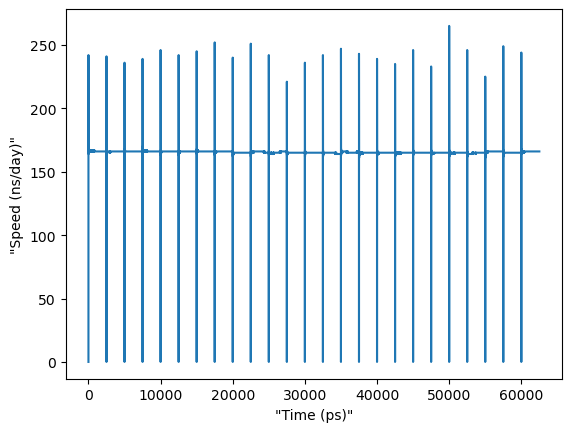

In [39]:
for i, (key, val) in enumerate(data.items()):
    if i >= 2:
        plt.clf()
        plt.ylabel(key)
        plt.xlabel([key for key in data.keys()][1])
        _ = plt.plot(0.2 + np.arange(val.shape[0])/5, val)
        plt.show()

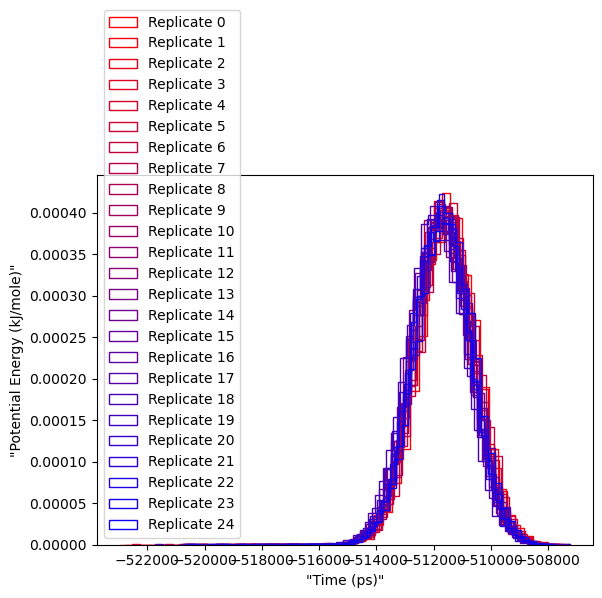

In [53]:
skip = 20
colors = [(1 - (i / num_replicates), 0, (i / num_replicates)) for i in range(num_replicates)]

plt.clf()
plt.ylabel([key for key in data.keys()][2])
plt.xlabel([key for key in data.keys()][1])
all_eners = data['"Potential Energy (kJ/mole)"']
for i, ind in enumerate(slice_indices):
    start = ind
    end = ind + 5*n_frames_per_replicate
    _ = plt.hist(all_eners[start + skip:end], density=True, bins=50, histtype='step', color=colors[i],
                 label=f"Replicate {ind//n_frames_per_replicate//5}")
plt.legend()
plt.show()

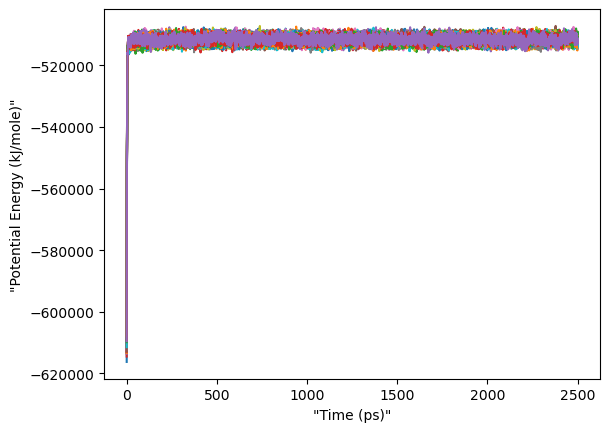

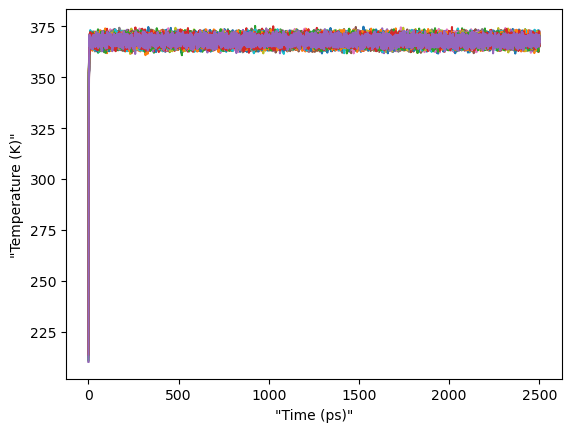

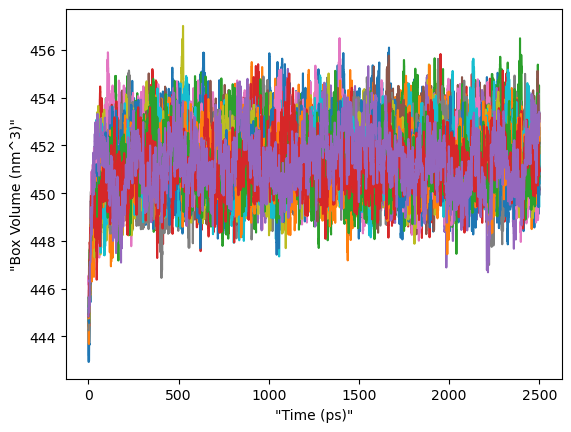

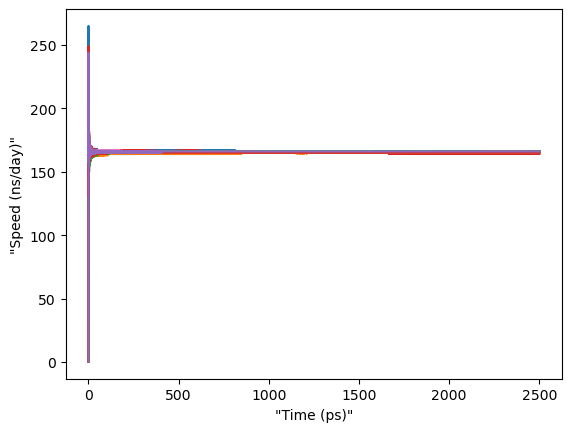

In [44]:
for i, (key, val) in enumerate(data.items()):
    if i >= 2:
        plt.clf()
        plt.ylabel(key)
        plt.xlabel([key for key in data.keys()][1])
        for ind in slice_indices:
            start = ind
            end = ind + 5*n_frames_per_replicate
            _ = plt.plot(data['"Time (ps)"'][start:end], val[start:end], label=f"Replicate {ind//n_frames_per_replicate}")
        plt.show()
    

In [69]:
prot_inds = mdtraj_topology.select('protein')
traj = md.load(dcd_fn, top=mdtraj_topology, atom_indices=prot_inds)

In [70]:
spring_centers_protein = [spring_center[prot_inds] for spring_center in spring_centers]

In [79]:
spring_center_traj = md.Trajectory(spring_centers_protein, mdtraj_topology.subset(prot_inds))

In [80]:
spring_center_traj = spring_center_traj.superpose(traj)

In [81]:
traj = traj.superpose(traj)

In [62]:
traj.save_dcd('test_US/test_trailblazing/protein_only.dcd')

In [85]:
spring_center_traj.save_dcd('test_US/test_trailblazing/spring_centers.dcd')

In [86]:
traj[0].save_pdb('test_US/test_trailblazing/protein_only.pdb')

In [82]:
spring_centers_protien = spring_center_traj.xyz
positions = traj.xyz

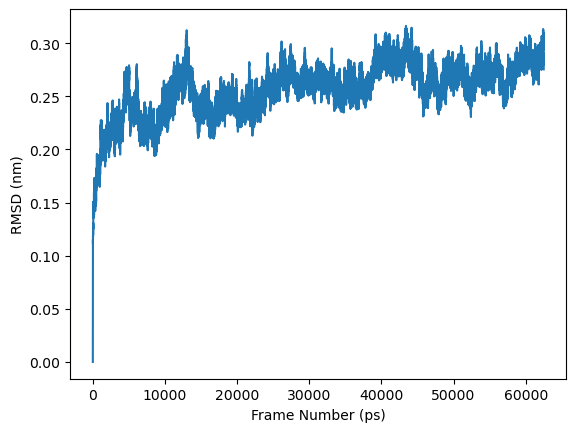

In [83]:
plt.clf()
rmsd_vals = rmsd(positions[0], positions)
_ = plt.plot(np.arange(rmsd_vals.shape[0])+1, rmsd_vals)
plt.xlabel('Frame Number (ps)')
plt.ylabel('RMSD (nm)')
plt.show()

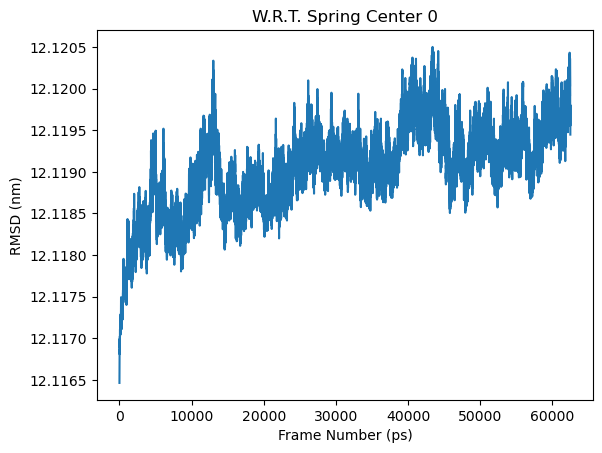

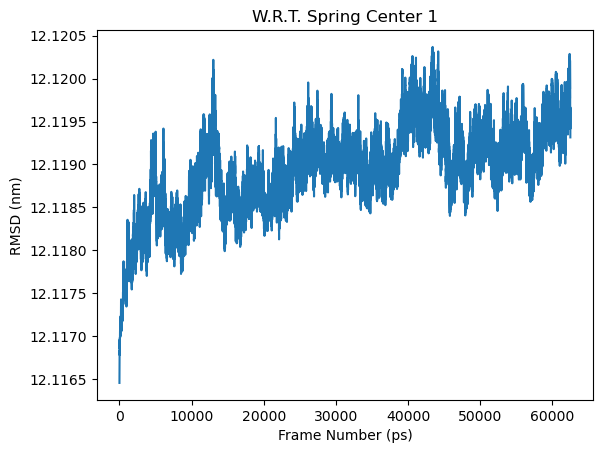

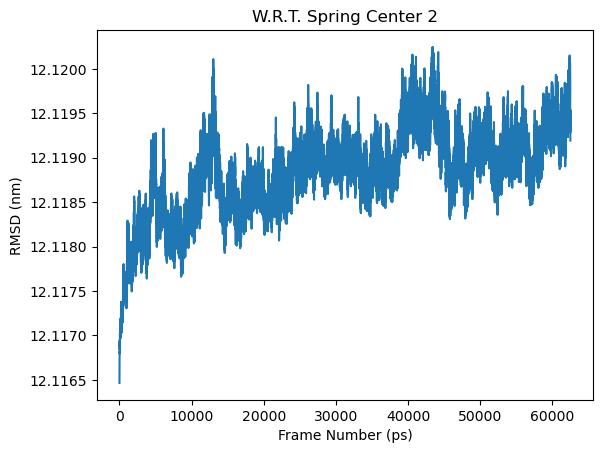

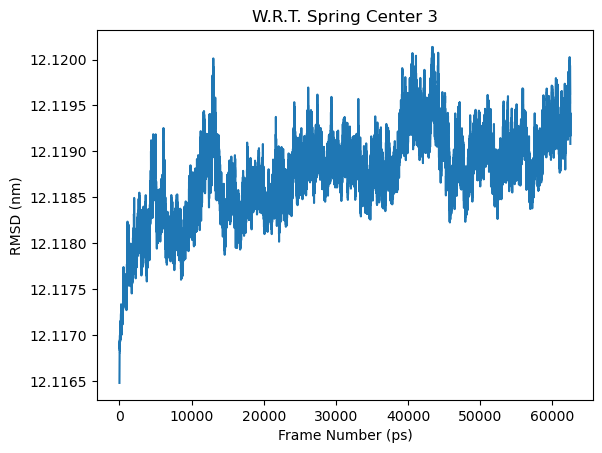

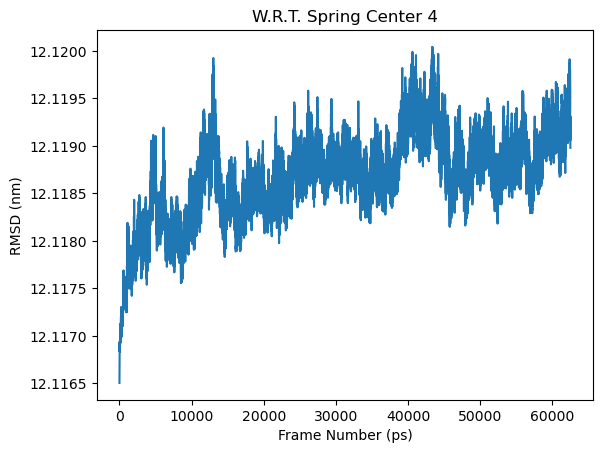

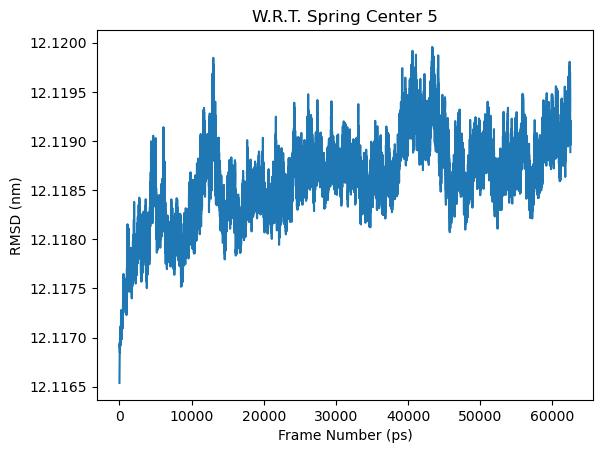

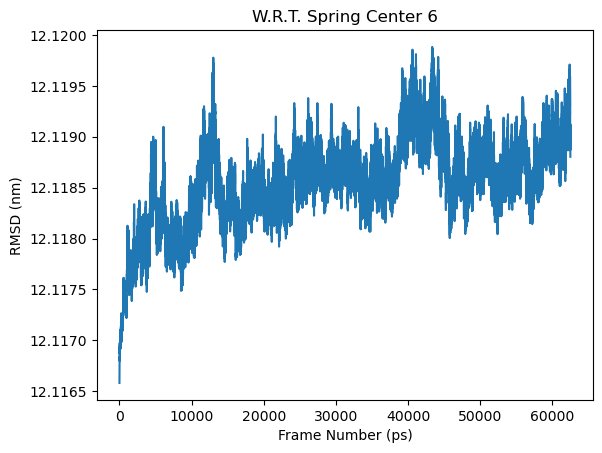

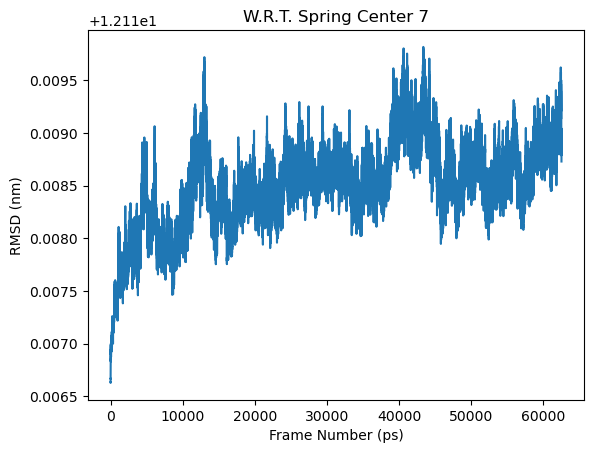

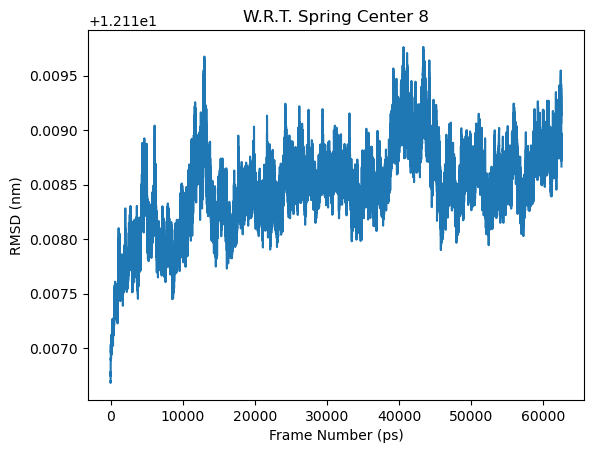

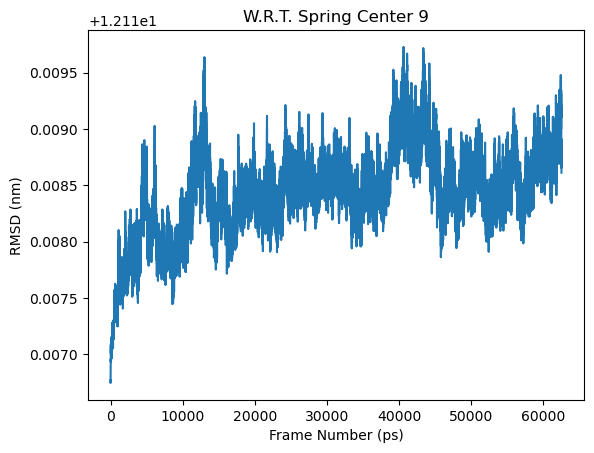

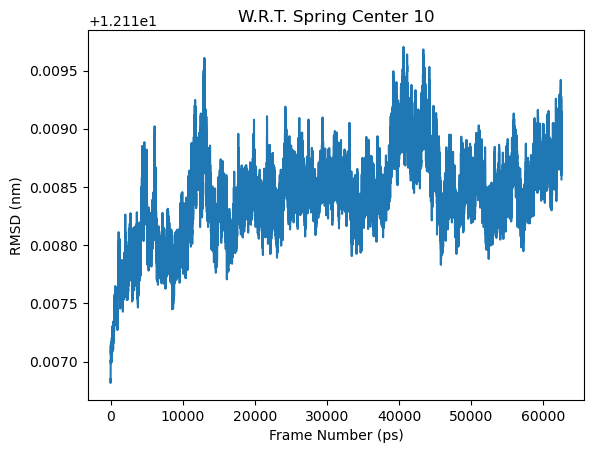

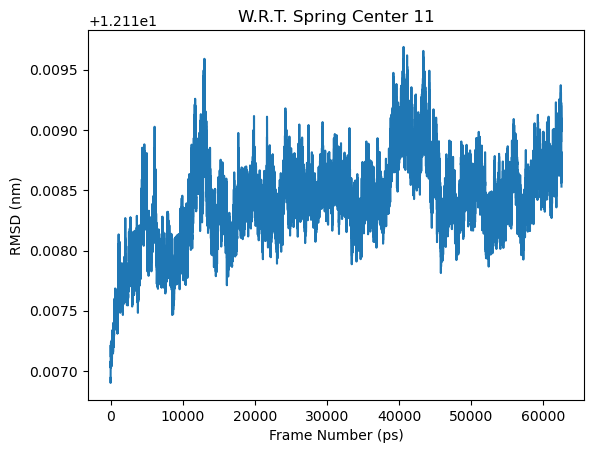

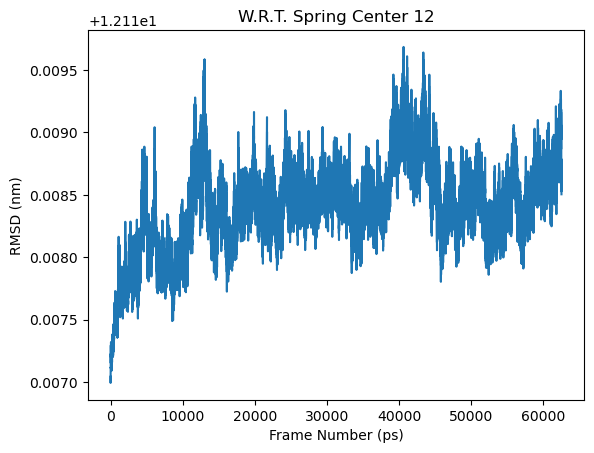

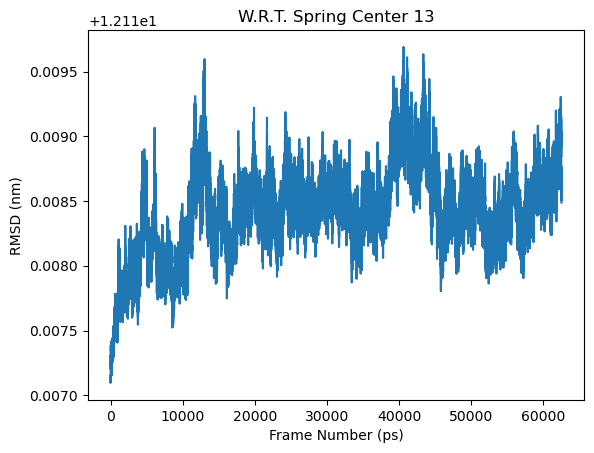

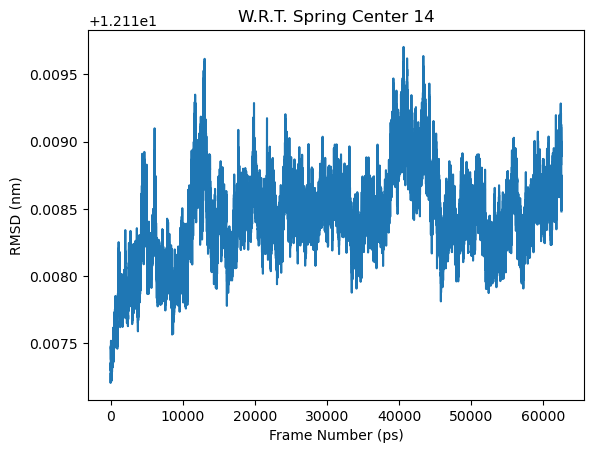

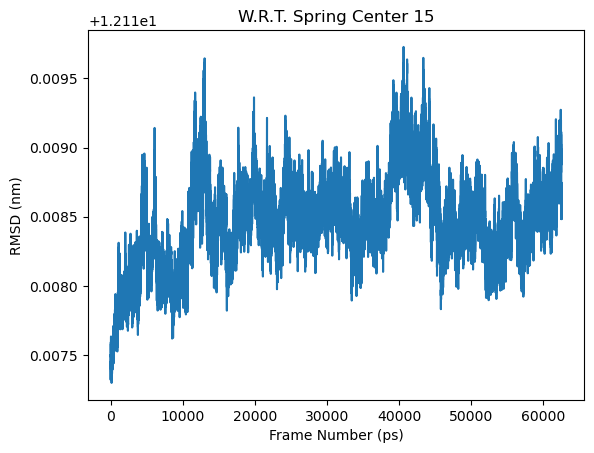

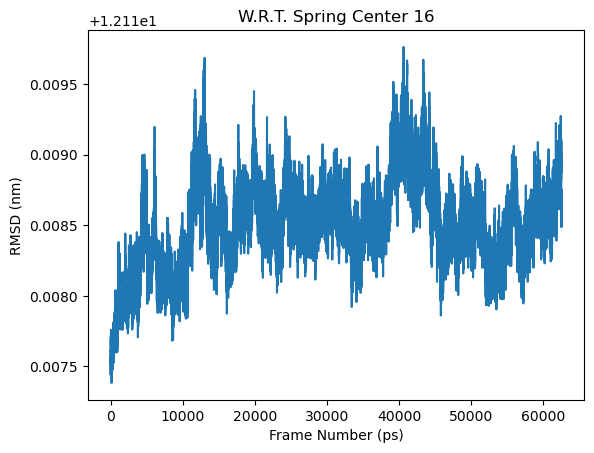

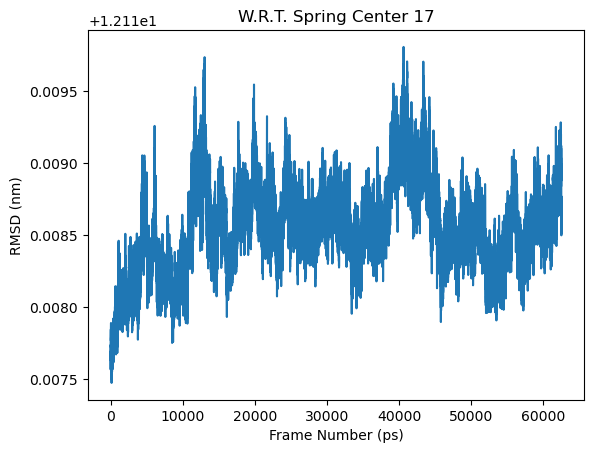

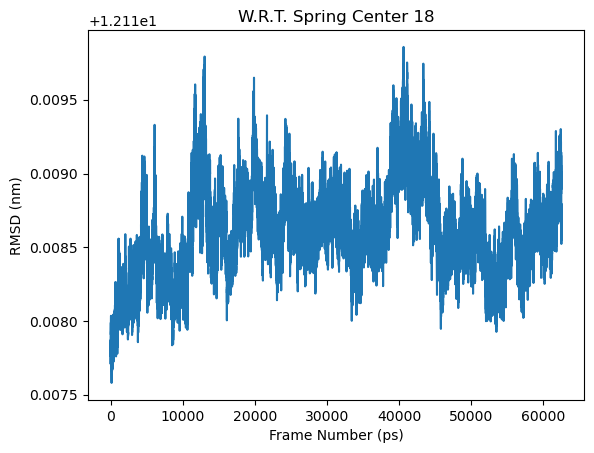

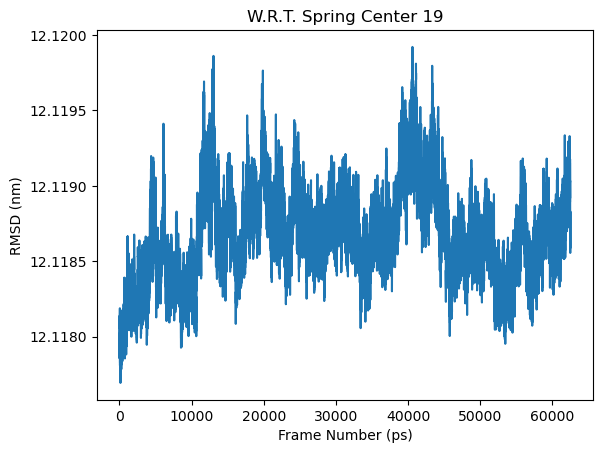

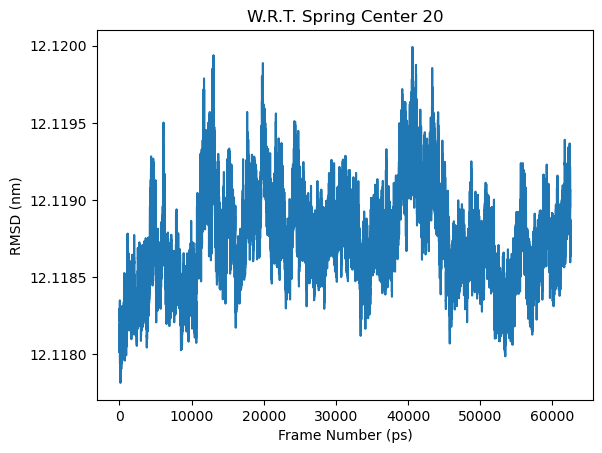

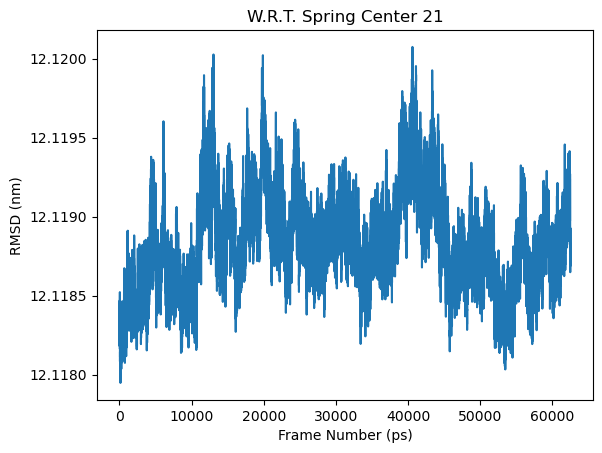

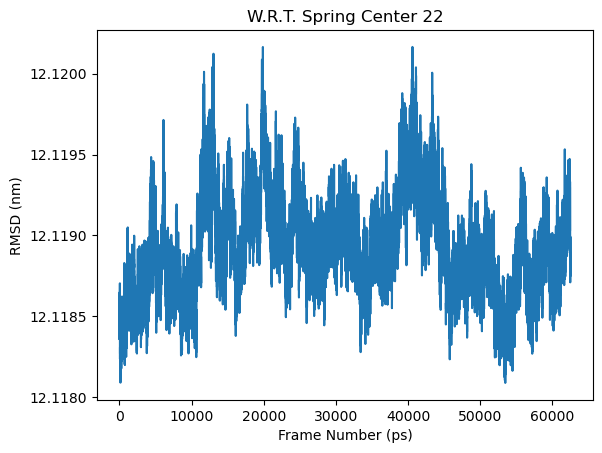

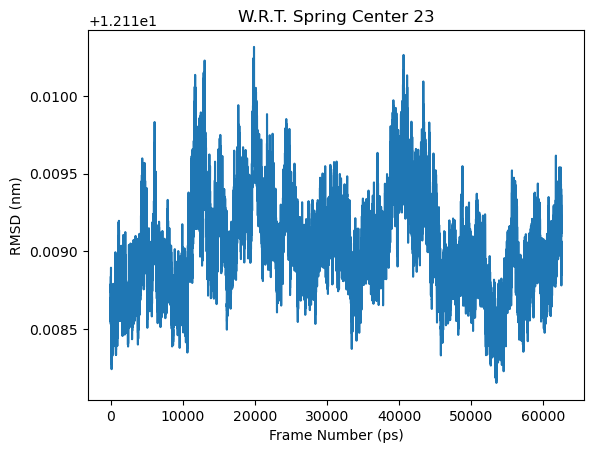

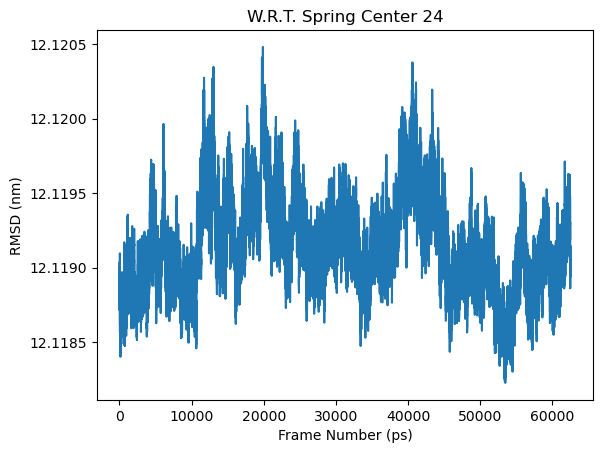

In [84]:
for i, spring_center_protein in enumerate(spring_centers_protein):
    rmsd_vals = rmsd(spring_center_protein, positions)
    plt.clf()
    _ = plt.plot(np.arange(rmsd_vals.shape[0])+1, rmsd_vals)
    plt.xlabel('Frame Number (ps)')
    plt.ylabel('RMSD (nm)')
    plt.title(f'W.R.T. Spring Center {i}')
    plt.show()

In [ ]:
#Get the spring centers from 2 PDBs
#set is (coords, inds, lambda_vals)
set1, set2 = make_interpolated_positions_array(centroid_8_files[0], centroid_1_files[0], num_replicates)

In [ ]:


topology = md.Topology.from_openmm(pdb.topology)

In [ ]:

kinetics = np.empty(n_frames_total)

In [ ]:
for i in range(set1[2].shape[0]):
    print(f"Starting State {i}")
    start_state = datetime.now()
    #Define the ThermoState
    thermo_state = ThermodynamicState(system_8, temperature=temp_max, pressure=pressure)
    #Define the SpringCenter
    spring_center = np.empty(set1[0].shape)
    spring_center[set1[1]] = set1[2][i]*set1[0][set1[1]] + set2[2][i]*set2[0][set2[1]]
    mask = np.full(set1[0].shape[0], True)
    mask[set1[1]] = False
    spring_center[mask] = set1[0][mask]
    restrain_atoms_by_dsl(thermo_state, topology, restraint_selection_string, spring_constant, spring_center)
    #Set the sampler state, depending if it is initial or later simulation
    if i == 0:
        sampler_state = SamplerState(init_positions, box_vectors=init_box_vectors)
    else:
        sampler_state = SamplerState(traj_xyz[npy_ind]*unit.nanometer,
                                     box_vectors=traj_box_vecs[i-1]*unit.nanometer)
    
    move = mcmc.GHMCMove(timestep=ts, n_steps=n_steps_per_frame)
    print("Finished Setup - Now Running!")
    
    for frame_i in range(n_frames_per_replicate):
        #Each frame, simulate
        move.apply(thermo_state, sampler_state)
        #obtain the index of the npy array to save to
        npy_ind = int(frame_i + n_frames_per_replicate*i)
        #update data
        traj_xyz[npy_ind] = sampler_state.positions._value
        potentials[npy_ind] = sampler_state.potential_energy._value
        kinetics[npy_ind] = sampler_state.kinetic_energy._value
    traj_box_vecs[i] = sampler_state.box_vectors._value
    print(f"Time for this state was {datetime.now() - start_state}")
    del thermo_state, sampler_state, move

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
_ = plt.plot(potentials)

In [ ]:
np.save('test_positions.npy', traj_xyz)
np.save('test_potentials.npy', potentials)
np.save('test_kinetics.npy', kinetics)

In [ ]:
imaged = prot_traj.image_molecules()

In [ ]:
rmsd = lambda a, b: np.sqrt(np.mean(np.sum((b-a)**2, axis=-1), axis=-1))

In [ ]:
#Plot the rmsd of the protein
prot_traj = traj_xyz[:, set1[1]]

In [ ]:
rmsd_wrt_inds = np.linspace(0, 4000, 9, dtype=int)
rmsd_wrt_inds = rmsd_wrt_inds[:-1]
colors = [(i/len(rmsd_wrt_inds), 0.5, 1 - (i/len(rmsd_wrt_inds))) for i in range(len(rmsd_wrt_inds))]

In [ ]:
rmsd_wrt_inds, colors

In [ ]:
rmsd_val_series = [rmsd(prot_traj[ind], prot_traj) for ind in rmsd_wrt_inds]

In [ ]:
for i, vals in enumerate(rmsd_val_series):
    plt.clf()
    _ = plt.plot(vals)
    plt.show()

In [ ]:
with md.formats.DCDTrajectoryFile('vis_shifting_centers.dcd', 'w') as f:
    f.write(traj_xyz * 10)

In [ ]:
plt.clf()
for i, ind in enumerate(rmsd_wrt_inds):
    rmsd_vals = rmsd(prot_traj[ind], prot_traj)
    _ = plt.plot(rmsd_vals, label=f"Ind {i}", c=colors[i])
plt.xlabel("Frame (ps)")

In [ ]:
#Try temperature as the scheduled parameter
starting_parameter_value = 300
final_parameter_value = 367.447
n_samples_per_state = 200
search_thermo_dist = 1.0

In [ ]:
test_tdstate = ThermodynamicState(system=openmm_system,
                                  temperature=starting_parameter_value*unit.kelvin,
                                  pressure=1.0*unit.bar)

mcmc_move = mcmc.LangevinDynamicsMove(timestep=2.0 * unit.femtosecond,
                                      collision_rate=1.0 / unit.picosecond,
                                      n_steps=n_samples_per_state,
                                      reassign_velocities=False)

sampler_state = SamplerState(positions = pdb.getPositions(asNumpy=True),
                             box_vectors = openmm_system.getDefaultPeriodicBoxVectors())

In [ ]:
previous_thermo_state = copy.deepcopy(test_tdstate)

In [ ]:
optimal_protocol = []
optimal_protocol.append(starting_parameter_value)

In [ ]:
while optical_protocol[-1] != final_parameter_value:
    #Simulate current state to collect samples
    sampler_states = []
    simulated_energies = np.zeros(n_samples_per_state)
    for i in range(n_samples_per_state):
        mcmc_move.apply(test_tdstate, sampler_state)
        sampler_states.append(copy.deepcopy(sampler_state))
    
    # Keep track of the thermo state we use for the reweighting.
    reweighted_thermo_state = None

    # Find first state that doesn't overlap with simulated one
    # with std(du) within search_thermo_dist +- distance_tolerance.
    # We stop anyway if we reach the last value of the protocol.
    std_energy = 0.0
    current_parameter_value = optimal_protocol[-1]
    while (abs(std_energy - search_thermo_dist) > distance_tolerance and not (current_parameter_value == final_parameter_value and std_energy < search_thermo_dist)):
    
        # Determine next parameter value to compute.
        if np.isclose(std_energy, 0.0):
            # This is the first iteration or the two state overlap significantly
            # (e.g. small molecule in vacuum). Just advance by a +- 0.05 step.
            old_parameter_value = current_parameter_value
            current_parameter_value += (values[1] - values[0]) / 20.0
        else:
            # Assume std_energy(parameter_value) is linear to determine next value to try.
            derivative_std_energy = ((std_energy - old_std_energy) / (current_parameter_value - old_parameter_value))
            old_parameter_value = current_parameter_value
            current_parameter_value += (search_thermo_dist - std_energy) / derivative_std_energy
    
        # Keep current_parameter_value inside bound interval.
        if current_parameter_value > final_parameter_value:
            current_parameter_value = final_parameter_value
        assert (optimal_protocol[-1] - current_parameter_value) < 0
    
        # Determine the thermo states at which we need to compute the energies.
        # If this is the first attempt, compute also the reduced potential of
        # the simulated energies and the previous state to estimate the standard
        # deviation in the opposite direction.
        if reweighted_thermo_state is None:
            # First attempt.
            reweighted_thermo_state = copy.deepcopy(thermodynamic_state)
            computed_thermo_states = [reweighted_thermo_state, thermodynamic_state]
            if previous_thermo_state is not None:
                computed_thermo_states.append(previous_thermo_state)
        else:
            computed_thermo_states = [reweighted_thermo_state]
    
        # Set the reweighted state to the current parameter value.
        parameter_setters[state_parameter](reweighted_thermo_state, state_parameter, current_parameter_value)
    
        # Compute all energies.
        energies = np.empty(shape=(len(computed_thermo_states), n_samples_per_state))
        for i, sampler_state in enumerate(sampler_states):
            energies[:,i] = mmtools.states.reduced_potential_at_states(
                sampler_state, computed_thermo_states, mmtools.cache.global_context_cache)
    
        # Cache the simulated energies for the next iteration.
        if len(computed_thermo_states) > 1:
            simulated_energies = energies[1]
    
        # Compute the energy difference std in the direction: simulated state -> previous state.
        if len(computed_thermo_states) > 2:
            denergies = energies[2] - simulated_energies
            states_stds[1].append(float(np.std(denergies, ddof=1)))
    
        # Compute the energy difference std between the currently simulated and the reweighted states.
        old_std_energy = std_energy
        denergies = energies[0] - simulated_energies
        std_energy = np.std(denergies, ddof=1)
        print('trailblazing: state_parameter {}, simulated_value {}, current_parameter_value {}, std_du {}'.format(state_parameter, optimal_protocol[state_parameter][-1], current_parameter_value, std_energy))